<a href="https://colab.research.google.com/github/JonathanSum/Hugging-Face-Course/blob/main/HarveNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext seaborn 

In [ ]:
!pip install torch numpy matplotlib sacrebleu

     |████████████████████████████████| 54 kB 147 kB/s 


In [ ]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

CUDA: True
cuda:0


In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


<img src='http://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png' width="300px" />

Encoder and Decoder Stacks


Encoder
The encoder is composed of a stack of 
N
=
6
 identical layers.

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])



In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)

        return self.norm(x)

We employ a residual connection (cite) around each of the two sub-layers, followed by layer normalization (cite).

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is LayerNorm(x+Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself. We apply dropout(cite) to the output of each sub-layer, before it is added to the sub-layer input normaized.

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension d_model = 512.

In [ ]:
class SublayerConection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size"
        return x + self.dropout(sublayer(self.norm(x)))

<img src='http://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png' width="300px" />

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        # put an attention
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # put a feed forward
        return self.sublayer[1](x, self.feed_forward)

Decoder

The decoder is also composed of stack of N = 6 identical layers.

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a thrid sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, droupout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, droup), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)
        

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on  the known outputs at positions less than i.

In [ ]:
np.triu([[1,2,3],[4,5,6],[7,8,9]], 1)

array([[0, 2, 3],
       [0, 0, 6],
       [0, 0, 0]])

In [ ]:
t1 = np.triu([[1,2,3],[4,5,6],[7,8,9]], 1)

In [ ]:
torch.from_numpy(t1) == 0

tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]])

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [ ]:
a = np.array([1, 2, 3])
t = torch.from_numpy(a)

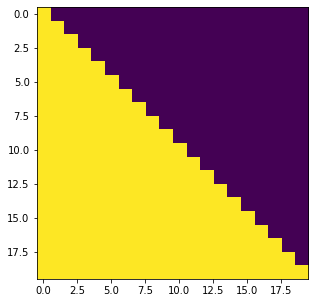

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of values, where the weight assigned to eachvalue is computed by a compatibility function of the query with the corresponding key.

We call our particular attention "Scaled Dot-Product Attention". The input consists of queries and keys of dimension d_k, and values of dimension d_v. We compute the dot products of the query with all keys, divide each by sqrt(d_k), and apply a softmax function to obtain the weights on the vlaues.

<img src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png" width="100px">

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V. We compute the matrix of outputs as:


Attention(Q,K,V) = softmax(QK^T/sqrt(d_k))V

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute  'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2,-1)) \
            /math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(masks == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)